In [1]:
import os

In [2]:
os.chdir('../')

In [3]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    test_data_path: Path
    model_path: Path
    all_params: dict
    metric_file_name: Path
    target_column: str

In [4]:
from Cardiovascular_Disease.constants import *
from Cardiovascular_Disease.utils.common import read_yaml, create_directories, save_json

In [5]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    
    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation
        params = self.params.LogisticRegression
        schema =  self.schema.TARGET_COLUMN

        create_directories([config.root_dir])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir=config.root_dir,
            test_data_path=config.test_data_path,
            model_path = config.model_path,
            all_params=params,
            metric_file_name = config.metric_file_name,
            target_column = schema.name
           
        )

        return model_evaluation_config

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report, precision_recall_curve
from urllib.parse import urlparse
import numpy as np
import joblib

In [22]:
class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config

    
    def eval_metrics(self, actual, pred):
        accuracy=accuracy_score(actual,pred)
        roc=roc_auc_score(actual,pred)
        print("Accuracy : ",'{0:.2%}'.format(accuracy))
        print("ROC_AUC Score : ",'{0:.2%}'.format(roc))
            
        return accuracy, roc
    


    def save_results(self):

        test_data = pd.read_csv(self.config.test_data_path)
        model = joblib.load(self.config.model_path)

        test_x = test_data.drop([self.config.target_column], axis=1)
        test_y = test_data[[self.config.target_column]]
        
        predicted_qualities = model.predict(test_x)
        RocCurveDisplay.from_estimator(model, test_x, test_y)
        plt.title('ROC_AUC_Plot')
        plt.show()
        (accuracy, roc) = self.eval_metrics(test_y, predicted_qualities)
        
        # Saving metrics as local
        scores = {"accuracy": accuracy, "roc": roc}
        save_json(path=Path(self.config.metric_file_name), data=scores)

[2024-10-30 01:13:42,652: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-10-30 01:13:42,654: INFO: common: yaml file: params.yaml loaded successfully]
[2024-10-30 01:13:42,658: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-10-30 01:13:42,660: INFO: common: created directory at: artifacts]
[2024-10-30 01:13:42,663: INFO: common: created directory at: artifacts/model_evaluation]


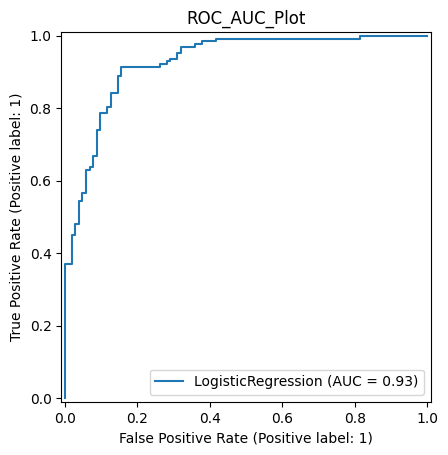

Accuracy :  87.83%
ROC_AUC Score :  87.42%
[2024-10-30 01:13:42,806: INFO: common: json file saved at: artifacts\model_evaluation\metrics.json]


In [23]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation_config = ModelEvaluation(config=model_evaluation_config)
    model_evaluation_config.save_results()
except Exception as e:
    raise e